In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pickle
import pandas as pd
import geopandas as gpd


import warnings
warnings.filterwarnings('ignore')


graph_filepath = "../data/iowa.graphml"
G = ox.load_graphml(graph_filepath)

states_shp_filepath = "../data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
states_map = gpd.read_file(states_shp_filepath)
iowa_map = states_map[states_map.name == 'Iowa']

towns_cleaned_filepath = "../data/towns_cleaned.pkl"
with open(towns_cleaned_filepath, "rb") as f:
    towns = pickle.load(f)

past_routes = pd.read_csv('../data/past_routes.csv')

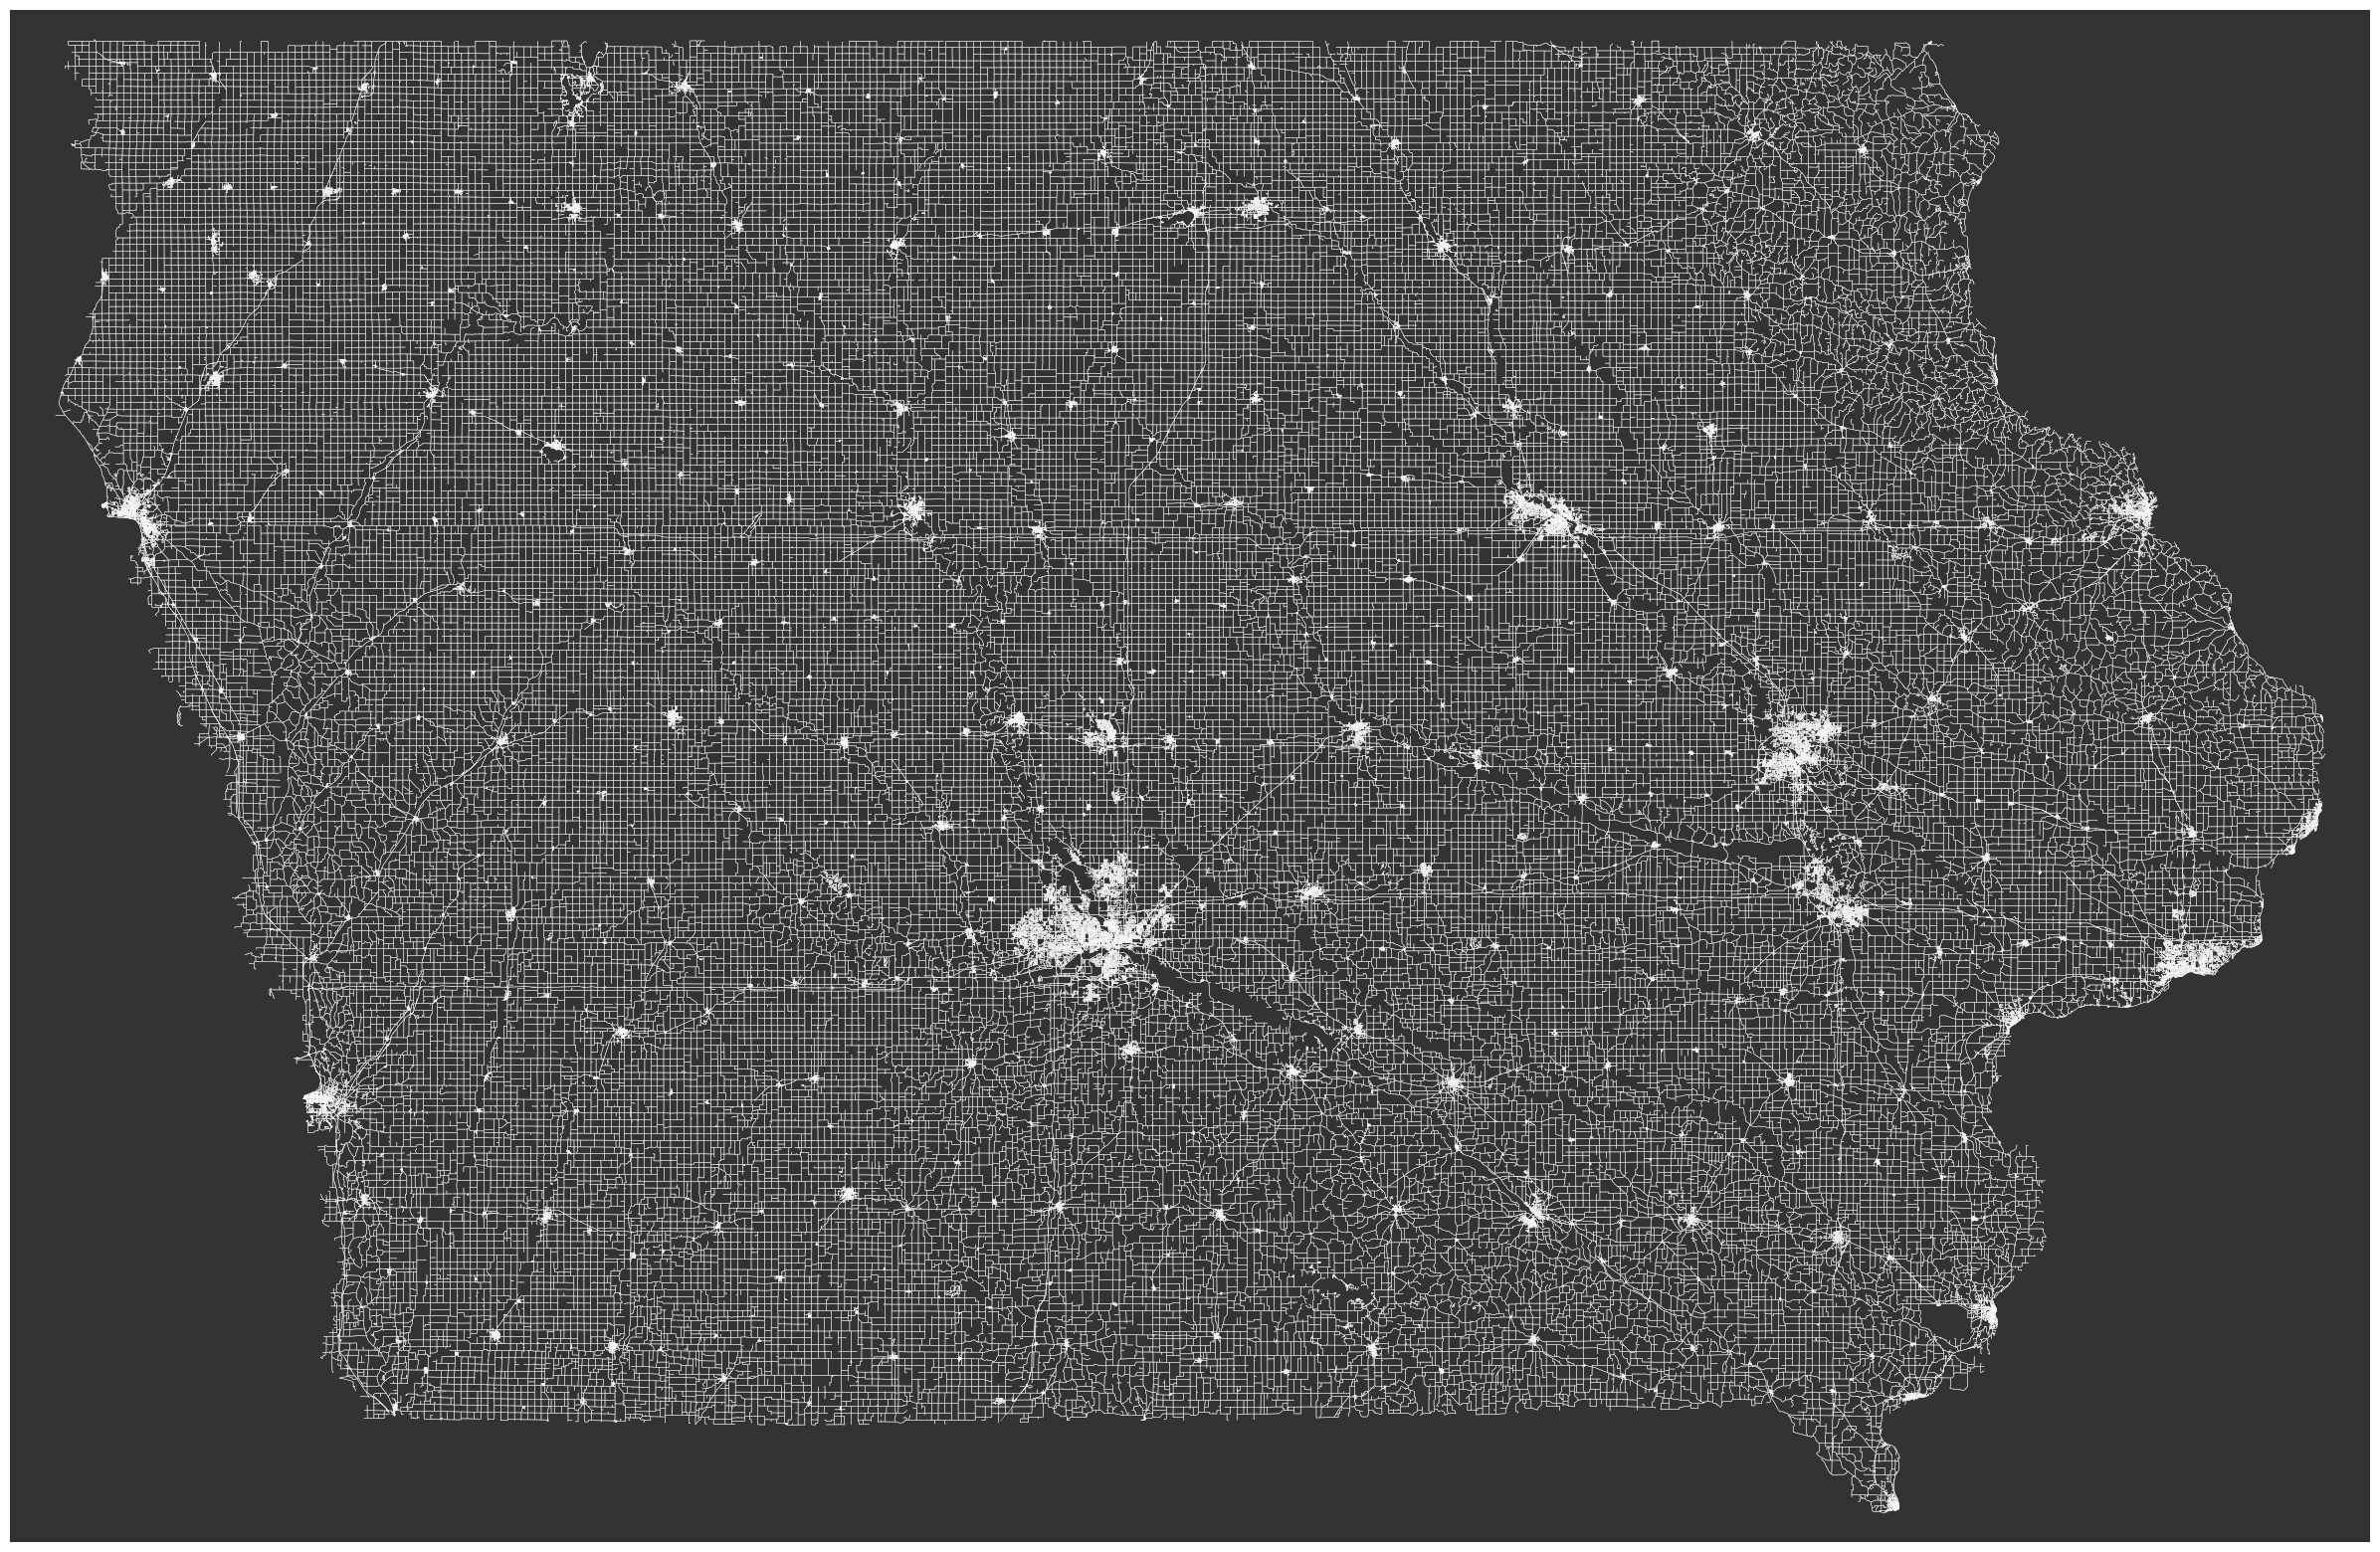

In [17]:
fig, ax = ox.plot_graph(
    G,
    figsize=(34, 20),
    # show=False,
    # close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=0,
)

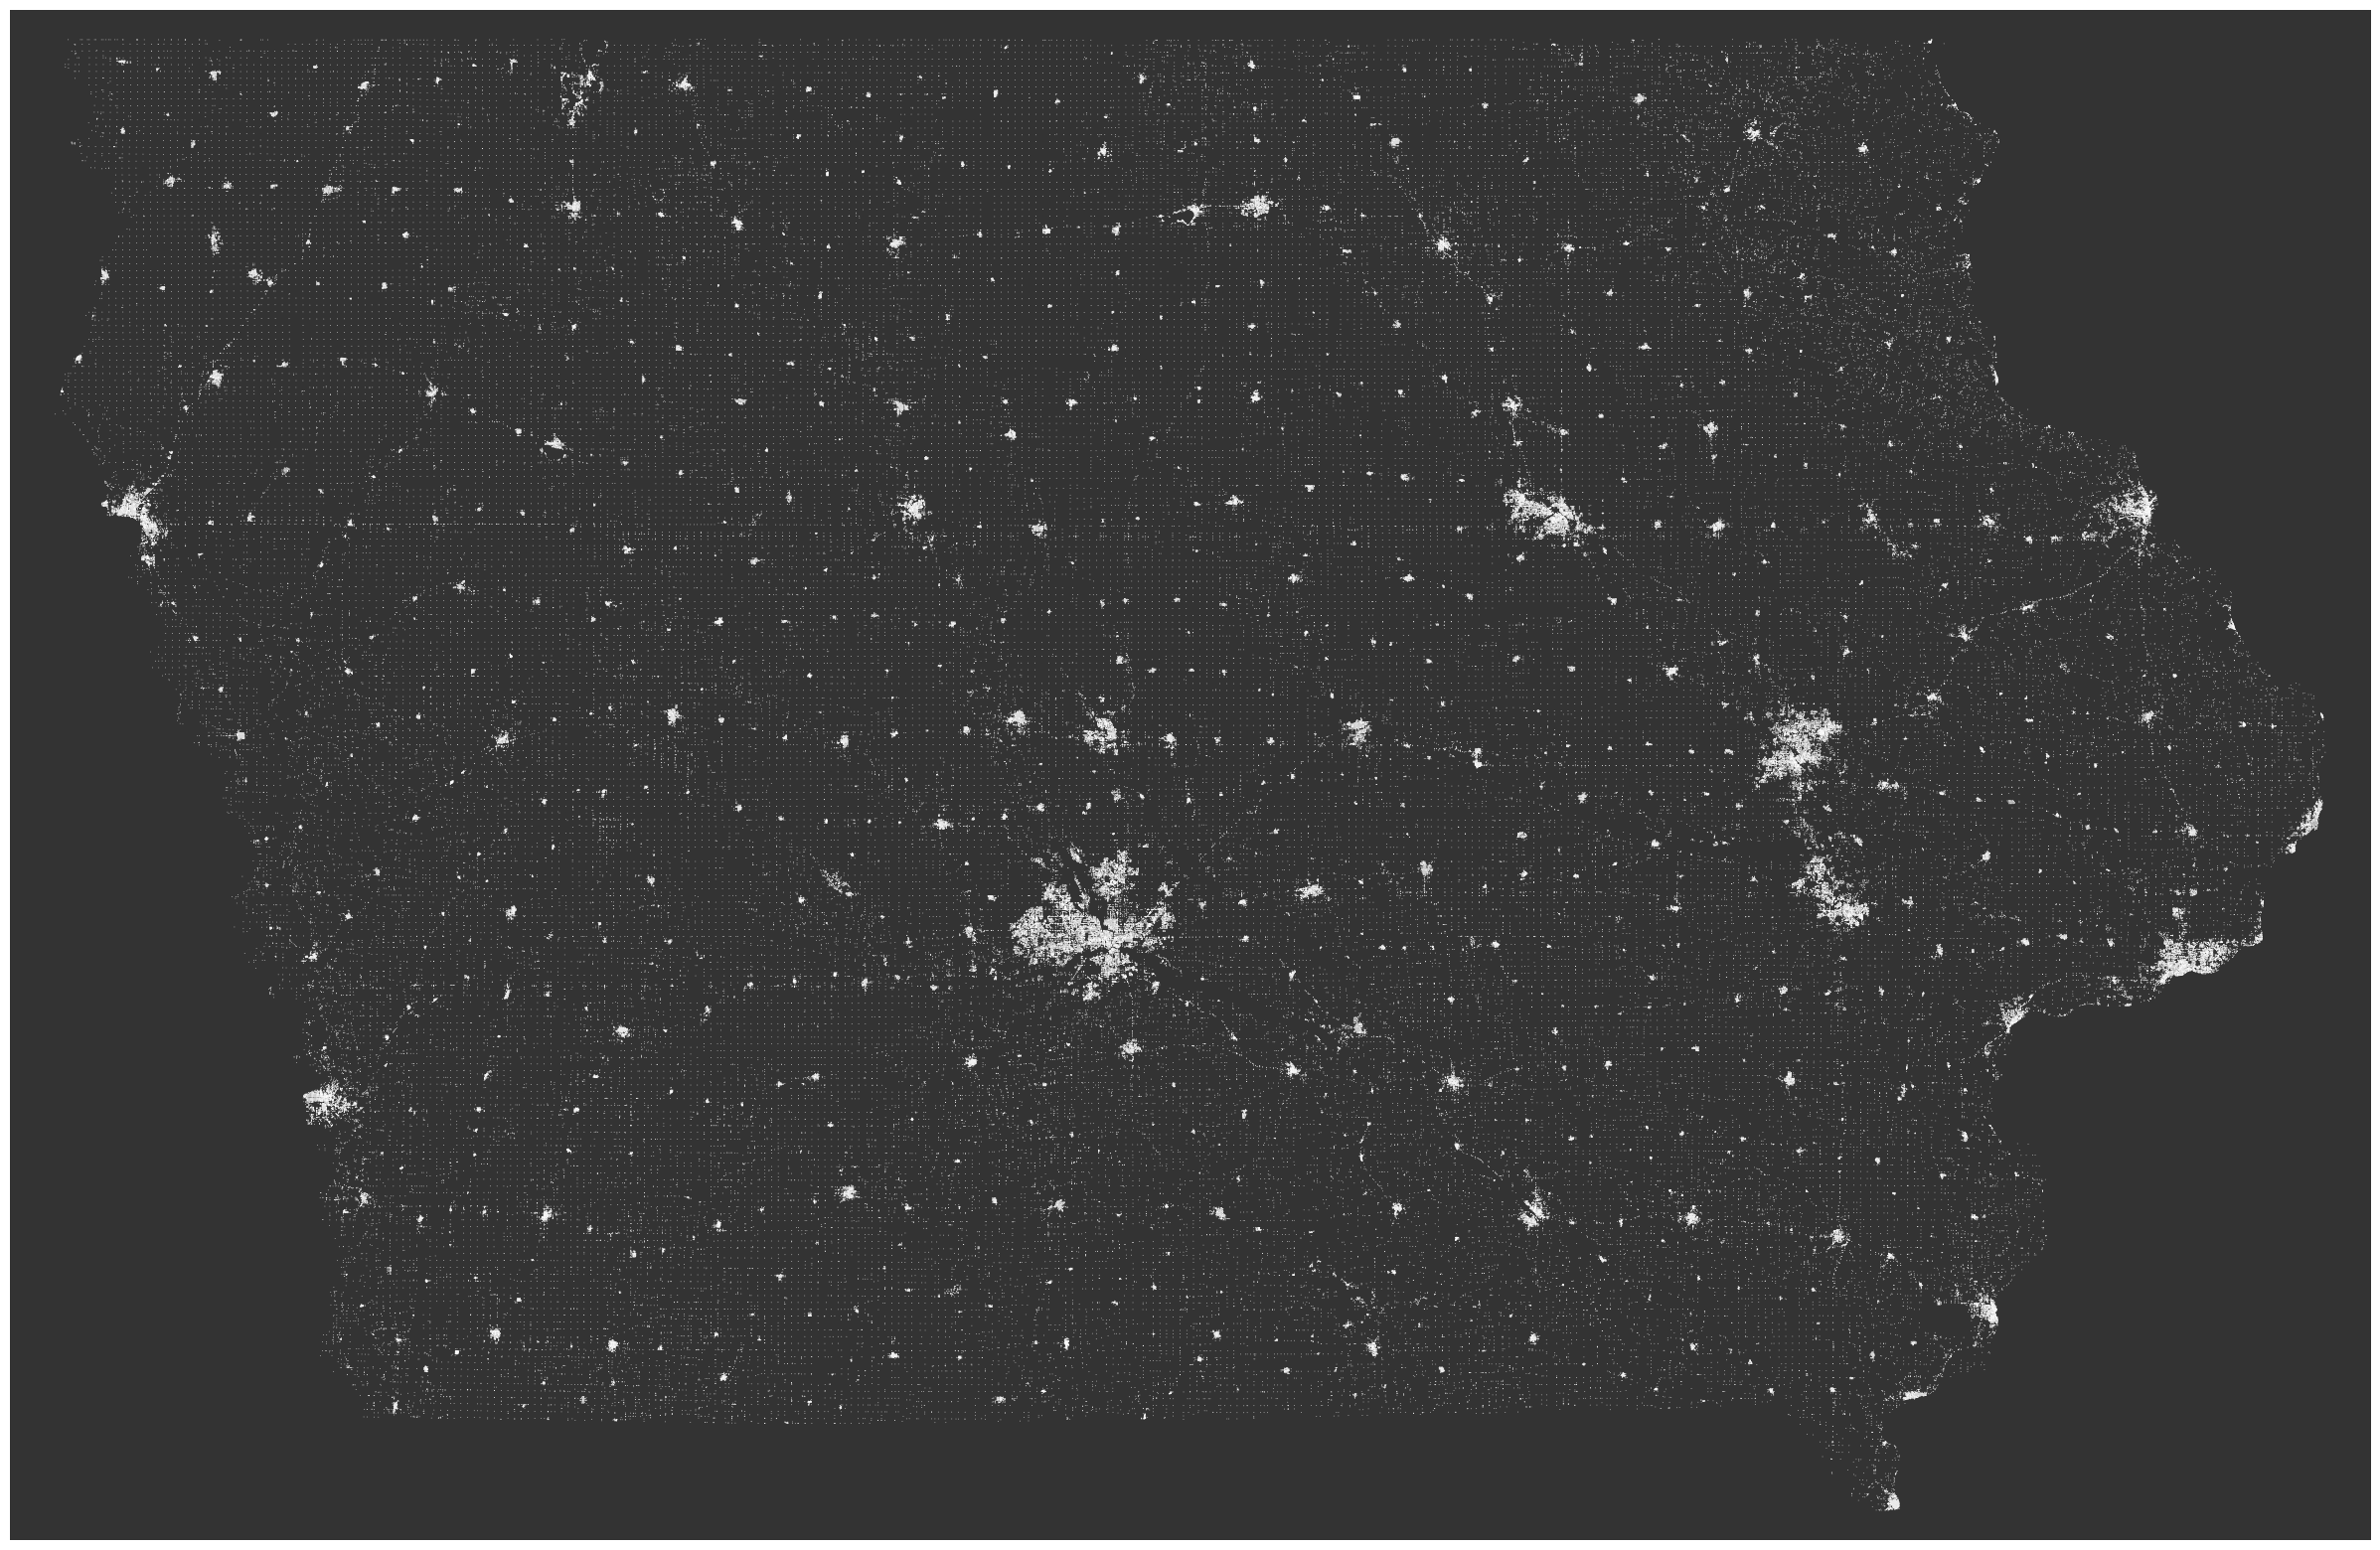

In [18]:
fig, ax = ox.plot_graph(
    G,
    figsize=(34, 20),
    # show=False,
    # close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0,
    node_size=0.3,
)

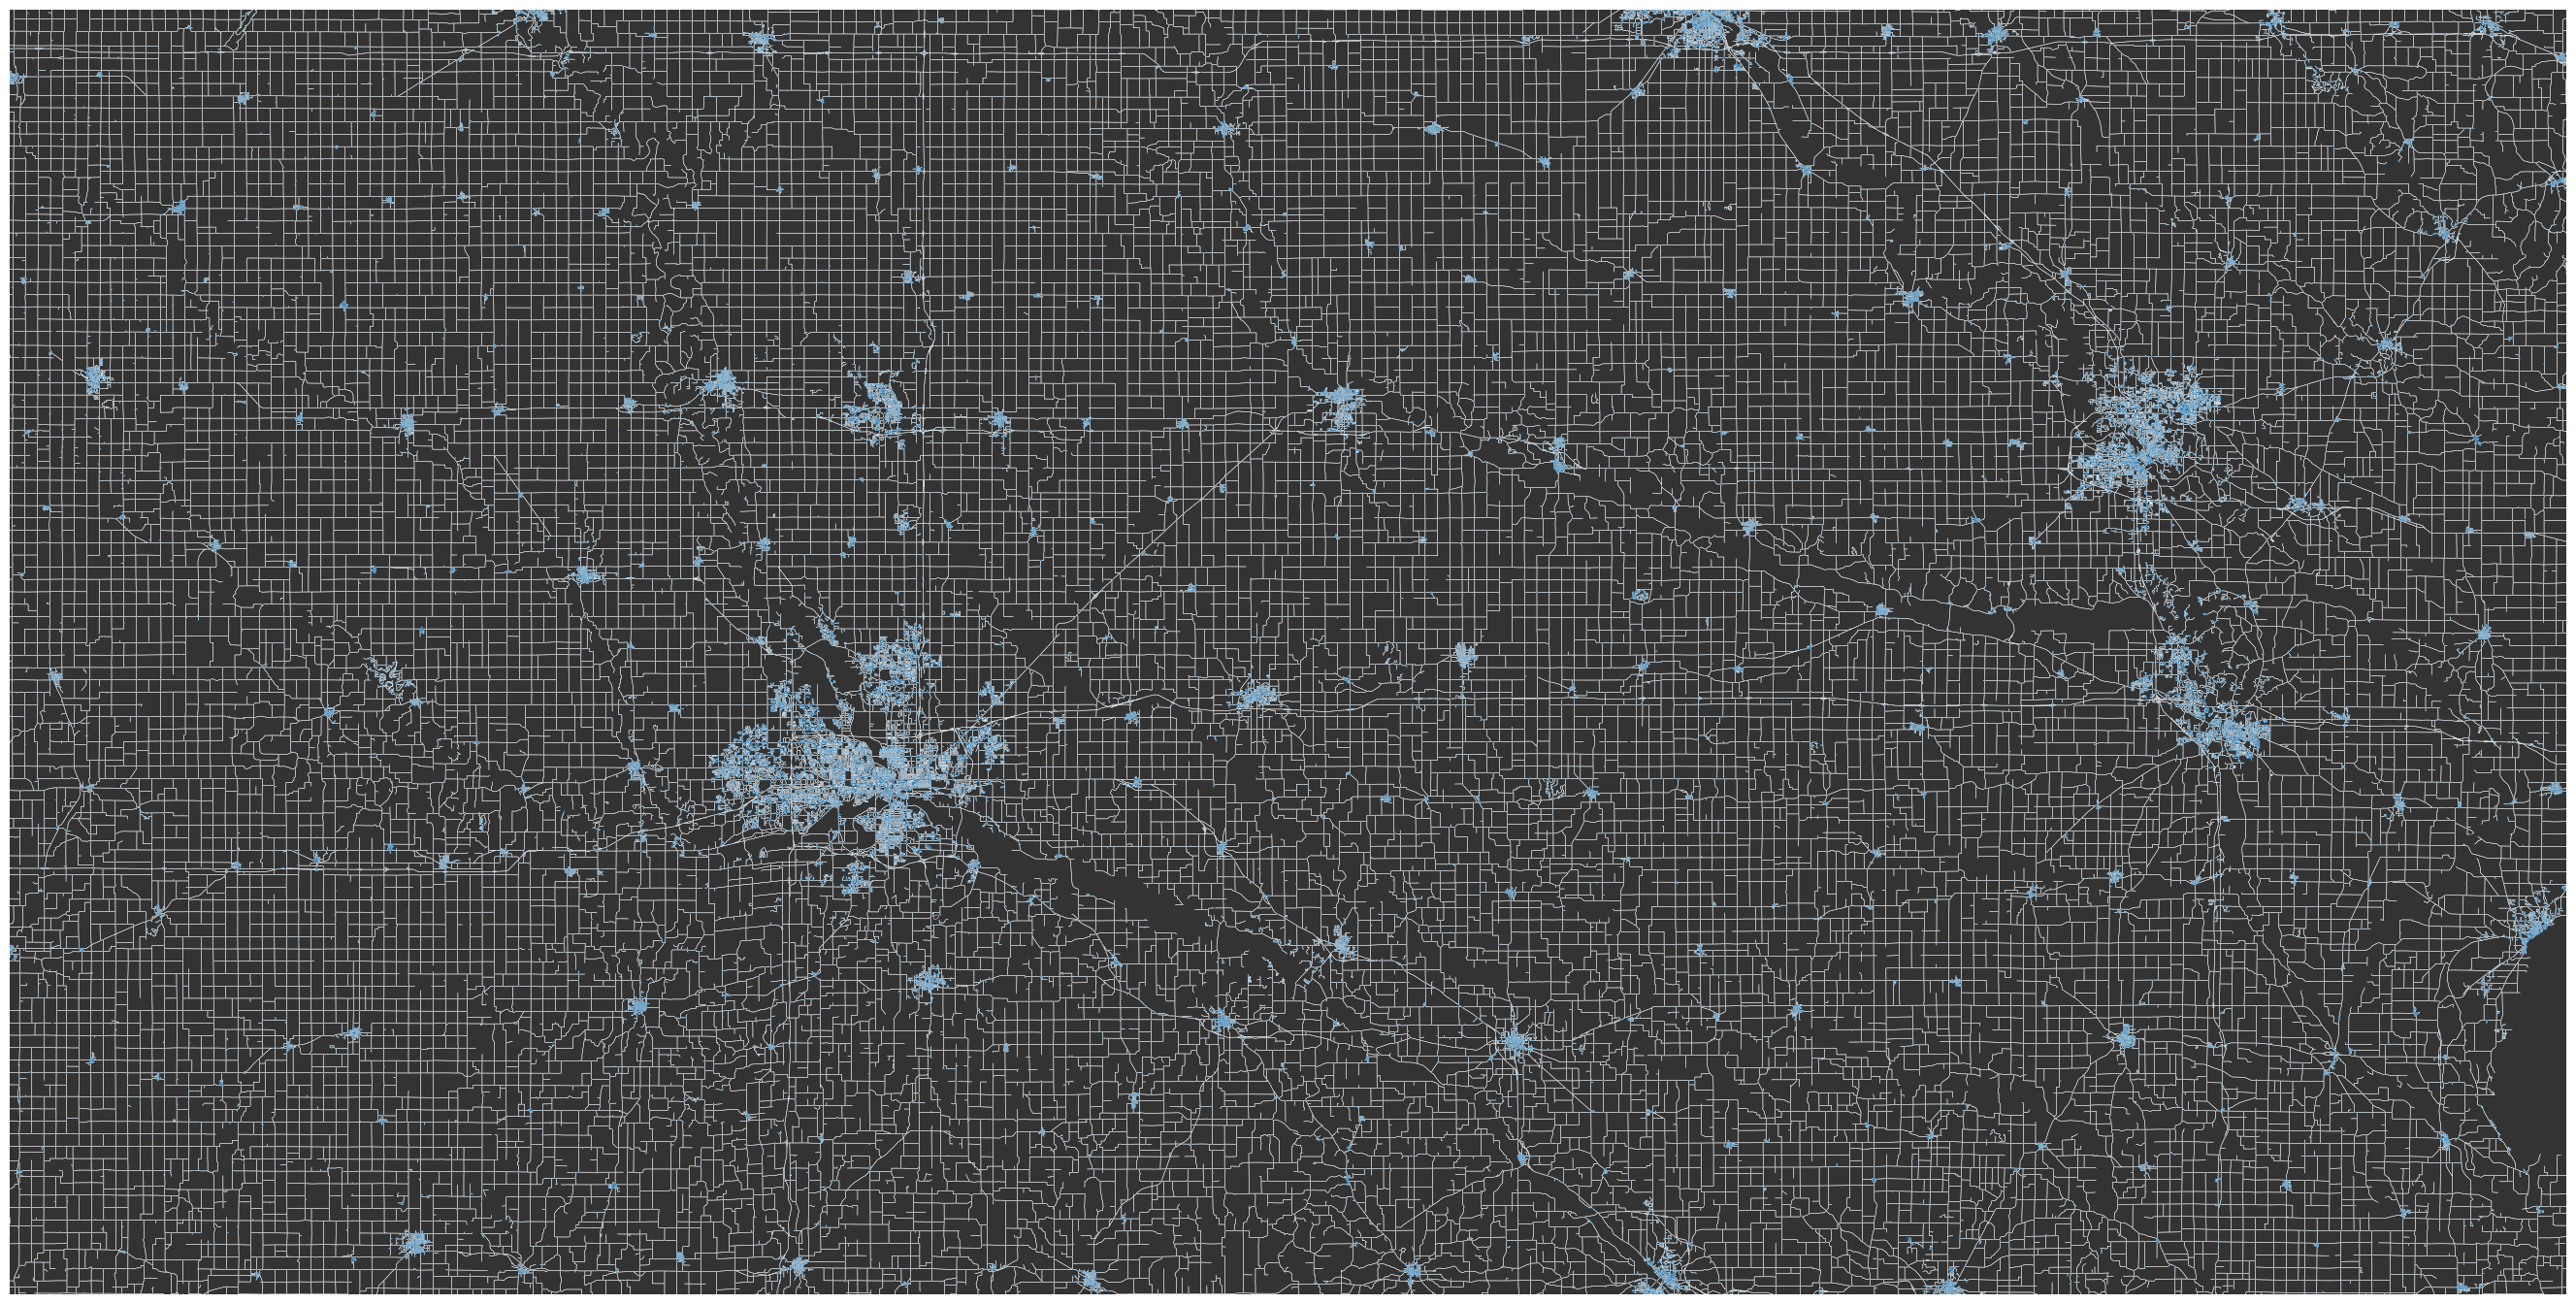

In [54]:
fig, ax = ox.plot_graph(
    G,
    figsize=(34, 20),
    # show=False,
    # close=False,
    bgcolor="#333333",
    # bgcolor="#fff",
    node_color='tab:blue',
    edge_color="w",
    edge_linewidth=0.3,
    node_size=0.3,
    bbox = (42.5, 41, -91, -95)
)

In [29]:
for n in G.neighbors(160288534):
    print(n)

160288553
160288482
160277932


In [30]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [27]:
G.has_node(160288534)
#[160288534]

True

In [45]:
town_coords = list(zip(towns.centroid.y, towns.centroid.x))

# Function to find nearest node in the graph to a given point
def get_nearest_node(point):
    return ox.nearest_nodes(G, point[0], point[1])

# Map town centroids to nearest graph nodes
town_nodes = [get_nearest_node((lon, lat)) for lat, lon in town_coords]

In [15]:
town_coords[:5]

[(41.36618200357139, -93.47258745474791),
 (41.61012495920923, -94.01181960535128),
 (40.9969846065603, -92.30729095405624),
 (41.290127727872665, -91.55450244129024),
 (41.02671008363439, -92.80368045429725)]

In [46]:
town_nodes[:5]

[161229705, 159443403, 161263545, 161261944, 160509637]

In [56]:
# Function to compute distance between nodes (towns)
def compute_distance(G, node1, node2):
    # Multiply by 0.000621371 to convert meters to miles
    meters = nx.shortest_path_length(G, node1, node2, weight='length')
    miles = meters * 0.000621371
    return miles

# Build a list of towns that are 35-75 miles apart
MIN_DAILY_DIST = 35
MAX_DAILY_DIST = 75
selected_towns = [town_nodes[0]]  # Start from the first town
current_node = town_nodes[0]

In [57]:
node = town_nodes[1]
distance = compute_distance(G, current_node, node)
distance

42.912289500746994

In [12]:
towns

element_type   osmid         name place population             wikipedia  \
0       relation  128768     Ackworth  city        115     en:Ackworth, Iowa   
1       relation  129250         Adel  town       6153         en:Adel, Iowa   
2       relation  129032       Agency  city        620       en:Agency, Iowa   
3       relation  128890    Ainsworth  city        511    en:Ainsworth, Iowa   
4       relation  128748        Albia  town       3721        en:Albia, Iowa   
..           ...     ...          ...   ...        ...                   ...   
766     relation  128824  Worthington  city        382  en:Worthington, Iowa   
767     relation  129132         Yale  city        267         en:Yale, Iowa   
768     relation  129207       Yetter  city         19       en:Yetter, Iowa   
769     relation  129283     Yorktown  city         60     en:Yorktown, Iowa   
770     relation  128825      Zwingle  city         84      en:Zwingle, Iowa   

                                              geometry      county  \
0    POLYGON ((-93.47793 41.37143, -93.46665 41.371...      Warren   
1    POLYGON ((-94.01198 41.61467, -94.01209 41.615...      Dallas   
2    POLYGON ((-92.31455 40.99681, -92.31443 40.996...     Wapello   
3    POLYGON ((-91.55943 41.29440, -91.55941 41.294...  Washington   
4    POLYGON ((-92.79351 41.04495, -92.79356 41.044...      Monroe   
..                                                 ...         ...   
766  POLYGON ((-91.12600 42.40451, -91.12579 42.404...     Dubuque   
767  POLYGON ((-94.36275 41.77673, -94.36263 41.779...     Guthrie   
768  POLYGON ((-94.84808 42.31804, -94.84314 42.317...     Calhoun   
769  POLYGON ((-95.15915 40.73906, -95.15755 40.739...        Page   
770  POLYGON ((-90.68569 42.30283, -90.68331 42.294...        None   

                       centroid  
0    POINT (-93.47259 41.36618)  
1    POINT (-94.01182 41.61012)  
2    POINT (-92.30729 40.99698)  
3    POINT (-91.55450 41.29013)  
4    POINT (-92.80368 41.02671)  
..                          ...  
766  POINT (-91.12040 42.39793)  
767  POINT (-94.35772 41.77570)  
768  POINT (-94.84317 42.31612)  
769  POINT (-95.15436 40.73530)  
770  POINT (-90.68743 42.29730)  

[754 rows x 9 columns]

In [66]:
import folium

ackworth = town_coords[0]
ackworth_node = town_nodes[0]
adel = town_coords[1]
adel_node = town_nodes[1]

path = nx.shortest_path(G, source=town_nodes[0], target=town_nodes[1], weight='length')

# Extracting the coordinates of the nodes in the path
path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

# Create a map centered at the midpoint of the two points
midpoint = ((ackworth[0] + adel[0]) / 2, (ackworth[1] + adel[1]) / 2)
m = folium.Map(location=midpoint, zoom_start=10)

# Add the start and end points
folium.Marker(location=ackworth, popup="Ackworth", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=adel, popup="Adel", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(location=(G.nodes[ackworth_node]['y'], G.nodes[ackworth_node]['x']), popup="Closest Start Node").add_to(m)
folium.Marker(location=(G.nodes[adel_node]['y'], G.nodes[adel_node]['x']), popup="Closest End Node").add_to(m)

# Add the path to the map
folium.PolyLine(locations=path_nodes, color='blue', weight=5, opacity=0.7).add_to(m)

# Display the map
m

In [ ]:
def add_custom_weights(G):
    for u, v, data in G.edges(data=True):
        highway_type = data.get("highway", [])
        
        # Ensure highway_type is a list for consistent handling
        if isinstance(highway_type, str):
            highway_type = [highway_type]
        
        # Check if the road is an interstate (usually "motorway" or "motorway_link" in OSM)
        if "motorway" in highway_type or "motorway_link" in highway_type:
            # Assign a high weight to interstates
            data["custom_weight"] = data["length"] * 10  # Increase weight (or use float('inf') to exclude)
        else:
            # Use the normal length as weight for other roads
            data["custom_weight"] = data["length"]

# Add custom weights to the graph
add_custom_weights(G)

# Now calculate the shortest path avoiding/minimizing interstates
# Replace town_nodes[0] and town_nodes[1] with your actual node IDs
source = town_nodes[0]
target = town_nodes[1]

path = nx.shortest_path(G, source=source, target=target, weight="custom_weight")
path_length = nx.shortest_path_length(G, source=source, target=target, weight="custom_weight")

print("Shortest Path:", path)
print("Path Length:", path_length)

In [78]:
# all_types = [] 
# for u, v, data in G.edges(data=True):
#     highway_type = data.get("highway", [])
#     if highway_type not in all_types:
#         all_types.append(highway_type)
        
# all_types

In [68]:
def add_custom_weights(G, traffic_threshold=2500, truck_threshold=200):
    '''
    Calculates a custom weight from the length to bias road selection. 
    Ideally, we want to choose paved roads that have a traffic count of less than 2,500 cars per day and a truck count of less than 200.
    '''
    for u, v, data in G.edges(data=True):
        highway_type = data.get("highway", [])
        maxspeed = data.get("maxspeed", None)
        traffic_approximation = 0  # Initialize traffic approximation
        
        # Ensure highway_type is always a list
        if not isinstance(highway_type, list):
            highway_type = [highway_type]
        
        # Define road type penalties for busy roads
        busy_road_types = {"primary", "trunk", "motorway", "primary_link", "trunk_link", "motorway_link"}
        paved_road_types = {"residential", "tertiary", "secondary", "living_street"}
        
        # Check if the road is busy or paved
        is_busy = any(ht in busy_road_types for ht in highway_type)
        is_paved = any(ht in paved_road_types for ht in highway_type)
        
        # Approximate traffic volume based on road type and maxspeed
        if is_busy:
            traffic_approximation += 3000  # Estimated busy road traffic baseline
        
        # Handle maxspeed values
        if maxspeed:
            if isinstance(maxspeed, list):  # If maxspeed is a list, take the first numeric value
                maxspeed = next((int(speed) for speed in maxspeed if speed.isdigit()), None)
            elif isinstance(maxspeed, str) and maxspeed.isdigit():  # If maxspeed is a string, convert it
                maxspeed = int(maxspeed)
            else:
                maxspeed = None  # Fallback for non-numeric values
            
            if maxspeed:  # Add traffic based on valid maxspeed
                traffic_approximation += maxspeed * 10
        
        # Apply penalties based on traffic approximation
        if traffic_approximation > traffic_threshold or is_busy:
            data["custom_weight"] = data["length"] * 5  # Increase weight for busy roads
        elif is_paved:
            data["custom_weight"] = data["length"] * 1  # No penalty for paved roads
        else:
            data["custom_weight"] = data["length"] * 2  # Mild penalty for less desirable roads
        
        # Adjust further for truck count approximation
        truck_approximation = traffic_approximation * 0.1  # Assume 10% trucks
        if truck_approximation > truck_threshold:
            data["custom_weight"] *= 1.5  # Apply additional penalty

add_custom_weights(G)

In [74]:
# Create a map centered at the midpoint of the two points
midpoint = ((ackworth[0] + adel[0]) / 2, (ackworth[1] + adel[1]) / 2)
m = folium.Map(location=midpoint, zoom_start=10)

# Default length path
path = nx.shortest_path(G, source=town_nodes[0], target=town_nodes[1], weight='length')
path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
folium.PolyLine(locations=path_nodes, color='blue', weight=5, opacity=0.7).add_to(m)

# Custom weight
path = nx.shortest_path(G, source=town_nodes[0], target=town_nodes[1], weight='custom_weight')
path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
folium.PolyLine(locations=path_nodes, color='green', weight=5, opacity=0.7).add_to(m)

# Add the start and end points
folium.Marker(location=(G.nodes[ackworth_node]['y'], G.nodes[ackworth_node]['x']), popup="Closest Start Node").add_to(m)
folium.Marker(location=(G.nodes[adel_node]['y'], G.nodes[adel_node]['x']), popup="Closest End Node").add_to(m)

# Display the map
m

Now, lets find possible routes from Sioux Center -> Dubuque

- Starting Town = Sioux Center
- Sunday
- Monday
- Tuesday
- Wednesday
- Thursday
- Friday
- Ending Town = Dubuque

Filtering to only include 500+ populations

In [87]:
import numpy as np
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
    - lon1, lat1: Longitude and latitude of the first point in decimal degrees.
    - lon2, lat2: Longitude and latitude of the second point in decimal degrees.
    
    Returns:
    - Distance in miles.
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Differences
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 

    # Haversine formula 
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a)) 

    # Radius of Earth in miles
    r = 3956  
    return c * r

populated_towns = towns[towns.population > 500]

# Check if 'lon' and 'lat' columns exist; if not, extract from 'centroid'
if 'lon' not in populated_towns.columns or 'lat' not in populated_towns.columns:
    populated_towns['lon'] = populated_towns.centroid.x
    populated_towns['lat'] = populated_towns.centroid.y
    
# town_coords = list(zip(populated_towns.centroid.y, populated_towns.centroid.x))
# town_nodes = [get_nearest_node((lon, lat)) for lat, lon in town_coords]

In [122]:
def get_city_node(city):
    return get_nearest_node((towns[towns.name == city].centroid.x, towns[towns.name == city].centroid.y))[0]
    # return get_nearest_node((towns[towns.name == city].centroid.y, towns[towns.name == city].centroid.x))[0]

def get_city_latlon(city):
    return towns[towns.name == city].centroid.y.item(), towns[towns.name == city].centroid.x.item()

# curr_node = get_city_node(city='Sioux Center')
curr_node = get_city_node(city='Sioux Center')
end_node = get_city_node(city='Dubuque')
curr_lat, curr_lon = get_city_latlon(city='Sioux Center')
# start_node, end_node

In [124]:
# Calculate the distance from the start point to each town
populated_towns['distance_miles'] = haversine(
    curr_lon, curr_lat,
    populated_towns['lon'].values, populated_towns['lat'].values
)

# Apply filtering criteria
filtered_towns = populated_towns[
    (populated_towns['distance_miles'] >= 15) &
    (populated_towns['distance_miles'] <= 85) &
    (populated_towns['lon'] > curr_lon)
].copy()

# Reset index if desired
filtered_towns.reset_index(drop=True, inplace=True)

In [125]:
possible_nodes = ox.nearest_nodes(G, filtered_towns.centroid.x, filtered_towns.centroid.y)

In [128]:
# Function to compute distance between nodes (towns)
def compute_distance(G, node1, node2):
    meters = nx.shortest_path_length(G, node1, node2, weight='custom_weight')
    miles = meters * 0.000621371
    return miles

# Build a list of towns that are 35-75 miles apart
MIN_DAILY_DIST = 35
MAX_DAILY_DIST = 75

m = folium.Map(location=(curr_lat, curr_lon), zoom_start=10)
folium.Marker(location=(G.nodes[curr_node]['y'], G.nodes[curr_node]['x']), popup="Closest Start Node").add_to(m)

for next_node in possible_nodes:
    distance = compute_distance(G, curr_node, next_node)
    print(distance)
    path = nx.shortest_path(G, source=curr_node, target=next_node, weight='custom_weight')
    path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    if MIN_DAILY_DIST <= distance <= MAX_DAILY_DIST:
        folium.PolyLine(locations=path_nodes, color='green', weight=5, opacity=0.7).add_to(m)
    else:
        folium.PolyLine(locations=path_nodes, color='orange', weight=5, opacity=0.7).add_to(m)

m

70.89583936155897
72.258849582722
53.036408371092
111.29063773141063
93.28096948576497
80.92574502882746
90.04466954698847
48.663125329942986
85.13336869726358
68.29492389225999
89.58414571199197
77.85703941205796
79.55258191620997
80.972379233063
97.87189890434199
29.027444441618
27.073166781292002
102.393535514483
33.24007449620099
83.118818981994
23.215256925366003
43.427080461342996
56.226704797197996
80.24844131826251
77.911958045151


In [120]:
curr_lat, curr_lon

(43.074964629050605, -96.17083555472513)

In [123]:
m = folium.Map(location=(curr_lat, curr_lon), zoom_start=10)

folium.Marker(location=(G.nodes[curr_node]['y'], G.nodes[curr_node]['x']), popup="Closest Start Node").add_to(m)
# folium.Marker(location=(G.nodes[adel_node]['y'], G.nodes[adel_node]['x']), popup="Closest End Node").add_to(m)


m

In [ ]:
# Create a map centered at the midpoint of the two points
# midpoint = ((ackworth[0] + adel[0]) / 2, (ackworth[1] + adel[1]) / 2)


# Default length path
path = nx.shortest_path(G, source=town_nodes[0], target=town_nodes[1], weight='length')
path_nodes = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
folium.PolyLine(locations=path_nodes, color='blue', weight=5, opacity=0.7).add_to(m)

# Custom weight


# Add the start and end points
folium.Marker(location=(G.nodes[ackworth_node]['y'], G.nodes[ackworth_node]['x']), popup="Closest Start Node").add_to(m)
folium.Marker(location=(G.nodes[adel_node]['y'], G.nodes[adel_node]['x']), popup="Closest End Node").add_to(m)

# Display the map
m

In [88]:
populated_towns

element_type      osmid             name place population  \
1       relation     129250             Adel  town       6153   
2       relation     129032           Agency  city        620   
3       relation     128890        Ainsworth  city        511   
4       relation     128748            Albia  town       3721   
5       relation     129090        Alburnett  city        675   
..           ...        ...              ...   ...        ...   
756     relation     129262     Williamsburg  town       3346   
758         node  151405448           Wilton  town       2924   
759     relation     128337  Windsor Heights  city       5252   
760     relation     129061         Winfield  city       1033   
761     relation     128927        Winterset  town       5353   

                    wikipedia  \
1               en:Adel, Iowa   
2             en:Agency, Iowa   
3          en:Ainsworth, Iowa   
4              en:Albia, Iowa   
5          en:Alburnett, Iowa   
..                        ...   
756     en:Williamsburg, Iowa   
758           en:Wilton, Iowa   
759  en:Windsor Heights, Iowa   
760         en:Winfield, Iowa   
761        en:Winterset, Iowa   

                                              geometry      county  \
1    POLYGON ((-94.01198 41.61467, -94.01209 41.615...      Dallas   
2    POLYGON ((-92.31455 40.99681, -92.31443 40.996...     Wapello   
3    POLYGON ((-91.55943 41.29440, -91.55941 41.294...  Washington   
4    POLYGON ((-92.79351 41.04495, -92.79356 41.044...      Monroe   
5    POLYGON ((-91.61351 42.15669, -91.61356 42.143...        Linn   
..                                                 ...         ...   
756  POLYGON ((-92.02698 41.66274, -92.02815 41.662...        Iowa   
758                         POINT (-91.01682 41.58892)        None   
759  POLYGON ((-93.72678 41.61473, -93.72674 41.614...        Polk   
760  POLYGON ((-91.44752 41.11749, -91.44752 41.118...       Henry   
761  POLYGON ((-94.03272 41.33026, -94.03272 41.335...     Madison   

                       centroid  
1    POINT (-94.01182 41.61012)  
2    POINT (-92.30729 40.99698)  
3    POINT (-91.55450 41.29013)  
4    POINT (-92.80368 41.02671)  
5    POINT (-91.62020 42.14841)  
..                          ...  
756  POINT (-92.01005 41.66836)  
758  POINT (-91.01682 41.58892)  
759  POINT (-93.71280 41.60446)  
760  POINT (-91.43813 41.12591)  
761  POINT (-94.01883 41.33822)  

[280 rows x 9 columns]

In [ ]:
for node in town_nodes[1:]:
    distance = compute_distance(G, current_node, node)
    distance_miles = meters_to_miles(distance)
    if MIN_DAILY_DIST <= distance_miles <= MAX_DAILY_DIST:
        selected_towns.append(node)
        current_node = node